# COGS 108 - Final Project

### Overview

The anime community has a wide diaspora of individuals ranging from all ages and all locations across the globe. This has piqued our interest as we are curious about what the statistics are like for various users and how they like to interact with anime.

### Names

- Aaron Lee
- Cassie Zhu
- Tina Chen
- Dillon Handal
- Emery Lin

### Research Question

Could age affect the various genre types that a user would like?

### Background & Prior Work

This project is quite similar to movie recommendations except that we are examining a different type of dataset and medium. Thus, we can apply similar concepts that are quite useful. For example in this whitepaper, https://beta.vu.nl/nl/Images/werkstuk-fernandez_tcm235-874624.pdf, there are discussions of several approaches to Netflix movie recommender system. You can have a basic model that just recommends the popular titles; however, this approach may not be the most accurate given that users may not like the popular titles. For a more precise prediction, you can examine how close users could be or in fact, examine the similarity between the titles in terms of synopsis or content. 

In the pursuit to find a strong and accurate predictor, the whitepaper reveals comparisons of different models. Given the results of the comparison, they provide somewhat of a roadmap for routes or ideas we can possibly explore. We can try different types of models using all the available data in our dataset. This way we can plot and analyze the data to get meaningful conclusions about our question.


### Hypothesis

We believe that there are some generational differences in terms of anime preference. On a general level, we think that older people tend to prefer more serious genres (Seinen, etc.) compared to younger ones who would prefer genres such as shoujo or shounen.

# Dataset

Our datasets will consist of public data only. We chose to use public data because it is what’s mostly readily available and easily searched for. Our main source of data will be from the MyAnimeList website because it has the largest consolidation of the anime and manga titles as well as user rating lists. 

https://myanimelist.net/ - According to the MyAnimeList website forum, the statistics list over 6.5 million users. While a small fraction of users may be just dummy or throwaway accounts, the majority of users have actual ratings lists that we can use in our analysis. If we need to scrape this, we can use an API but we will also need to clean up the dataset so it is usable and there are no odd inputs.
	
https://www.kaggle.com/azathoth42/myanimelist - This dataset from Kaggle has already parsed and filtered out sensitive information. It has some useful information that we can examine. We also do not have to clean up the data for use.

https://jikan.moe/ - This API can be used to interface with MAL’s website to get useful information without having to scrape and parse the website manually. It will be important in being able to get more features to examine in solving our question.

# Data Analysis

We chose to use the above kaggle set because it was already cleaned and everything was set up. We just need to check that the distribution of data is normal or at least if there is any bias, we are able to spot it out immediately. Some data may not be accurate so we would also need to prune and check for those.

In [4]:
%matplotlib inline

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
from bs4 import BeautifulSoup
from time import sleep
from IPython.display import clear_output

In [5]:
# Configure libraries
# The seaborn library makes plots look nicer
sns.set()
sns.set_context('talk')

# Don't display too many rows/cols of DataFrames
pd.options.display.max_rows = 10
pd.options.display.max_columns = 10

# Round decimals when displaying DataFrames
pd.set_option('precision', 2)

In [32]:
# import cleaned csvs
animeFiltered = pd.read_csv('myanimelist/anime_filtered.csv')
usersFiltered = pd.read_csv('myanimelist/users_filtered.csv')
animelistFiltered = pd.read_csv('myanimelist/animelists_filtered.csv')

In [33]:
usersFiltered[:5]

,username,user_id,user_watching,user_completed,user_onhold,...,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes
0,karthiga,2255153,3,49,1,...,2013-03-03,2014-02-04 01:32:00,7.43,0.0,3391.0
1,RedvelvetDaisuki,1897606,61,396,39,...,2012-12-13,1900-05-13 02:47:00,6.78,80.0,7094.0
2,Damonashu,37326,45,195,27,...,2008-02-13,1900-03-24 12:48:00,6.15,6.0,4936.0
3,bskai,228342,25,414,2,...,2009-08-31,2014-05-12 16:35:00,8.27,1.0,10081.0
4,terune_uzumaki,327311,5,5,0,...,2010-05-10,2012-10-18 19:06:00,9.70,6.0,920.0


Since we're interested in the age distribution, we can plot the age groups and total anime watched per age group to get an idea if we have a balanced dataset.

In [45]:
# add age column to usersFiltered data frame
now = pd.Timestamp('now')

# remove the two users who have odd birth dates
usersCleaned = usersFiltered.drop([78772, 89578])

usersCleaned['birth_date'] = pd.to_datetime(usersCleaned['birth_date'], format='%Y-%m-%d')
usersCleaned['age'] = (now - usersCleaned['birth_date']).astype('<m8[Y]').astype(int)

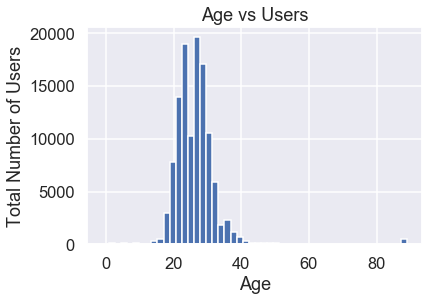

In [70]:
# plot histogram of age range
histogram = usersCleaned.hist(column="age", bins=50)
plt.title('Age vs Users')
plt.xlabel('Age')
plt.ylabel('Total Number of Users')
plt.show()

Given that our age range is mostly constricted around the twenties to forties, we can break our age group further into generational gaps to find a certain pattern that helps answer our research question.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


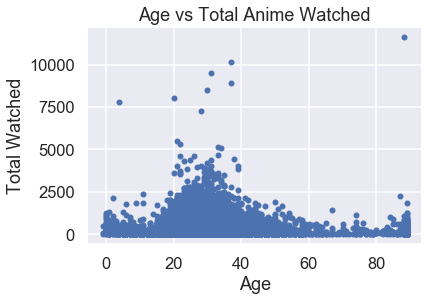

In [76]:
# plot age groups to total anime watching or completed
usersCleaned['total_watched'] = usersCleaned['user_watching'] + usersCleaned['user_completed']

plot = usersCleaned[['age', 'total_watched']].plot.scatter('age', 'total_watched')
plt.title('Age vs Total Anime Watched')
plt.xlabel('Age')
plt.ylabel('Total Watched')
plt.show()

It's interesting to see a rough distribution of how much anime certain age groups have watched. It seems like that the young adults age range has watched a lot of anime which could indicate a wide genre of anime they are interested in.

# Privacy / Ethics Considerations

In regards to the project, we are using publicly available data. However, the data needs to be cleaned as it contains location data and usernames. We will need to parse to make sure there are no odd revealing pieces of data around. Once we have accomplished this part, the data we use and display would not reveal any confidential information. Aside from this, we are in compliance with the Terms of Service provided by MyAnimeList so our data usage will be ethically safe. Furthermore, users on MyAnimeList are also able to restrict the view of their ratings list so if they did not want their ratings used by any third party application, they could simply restrict who is able to view their lists.

The data results from this project do not contain user sensitive information as everything is anonymized. The purpose of the project is just to see if there is a way to draw meaningful correlations between anime or manga to create predictions. However, the results of the project may have some biased results as we will end up selecting a random population from the total users on MAL. This may create bias since it’s possible that users may have a preference to certain kinds of anime over others which would skew the data analysis and prediction.

# Conclusion & Discussion

